In [1]:
%reset -f

In [2]:
import numpy as np
import torchdiffeq
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
from typing import List

In [3]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [4]:
# --- build a simple rod: 3 DOF per node (x,y,z) ---
def create_rod_with_nodes(num_nodes: int):
    nodes = []
    for i in range(num_nodes):
        nodes.append(np.array([i * 0.1, 0.0, 0.0], dtype=np.float32))
    return nodes
num_nodes = 11
nodes = create_rod_with_nodes(num_nodes)  # 11 nodes -> ndof = 33
q0 = np.array(nodes, dtype=np.float32).reshape(-1)         # positions (ndof,)
# v0 = np.zeros_like(q0, dtype=np.float32)                   # velocities (ndof,)
# give some nonzero init velocity to the free nodes
v0 = np.zeros_like(q0, dtype=np.float32)
# omega = 0.1
# for i in range(2, num_nodes):
#     v0[3*i + 2] = omega*(q0[3*i]-0.1) # z-velocities

x0 = torch.tensor(np.concatenate([q0, v0]), dtype=torch.float32)  # (2*ndof,)

print("Initial positions q0:", q0)
print("Initial velocities v0:", v0)
print("Initial state x0:", x0)

# create springs (3 consecutive nodes and effective length)
stretch_springs = []
bend_springs = []
for i in range(0, num_nodes):
    if i == 0:
        # boundary nodes: leff = 0.05
        l0 = np.linalg.norm(np.array(nodes[i+1] - nodes[i]))
        stretch_springs.append((i, i + 1, None, l0, None))
    elif i == num_nodes - 1:
        # boundary nodes: leff = 0.05
        l0 = np.linalg.norm(np.array(nodes[i] - nodes[i-1]))
        stretch_springs.append((i - 1, i, None, l0, None))
    else:
        # internal nodes: leff = 0.1
        l0 = np.linalg.norm(np.array(nodes[i] - nodes[i-1]))
        l1 = np.linalg.norm(np.array(nodes[i+1] - nodes[i]))
        leff = 0.5 * (l0 + l1)
        stretch_springs.append((i - 1, i, i + 1, l0, l1))
        bend_springs.append((i - 1, i, i + 1))


# Material properties
E = 1e7  # Young's modulus
r0 = 0.01  # radius
A = np.pi * r0**2  # cross-sectional area
I = 0.25 * np.pi * r0**4  # area moment of inertia
rho = 1200  # density
mass = rho*A*1  # mass per segment (length 1 m)
m_per_node = mass/num_nodes

EA = E * A  # axial stiffness
EI = E * I  # bending stiffness

# print("Stretch springs:", stretch_springs)
# print("Bend springs:", bend_springs)
print(f"EA={EA:.3e}, EI={EI:.3e}")
print(f"Mass per node={m_per_node:.3e}")


Initial positions q0: [0.  0.  0.  0.1 0.  0.  0.2 0.  0.  0.3 0.  0.  0.4 0.  0.  0.5 0.  0.
 0.6 0.  0.  0.7 0.  0.  0.8 0.  0.  0.9 0.  0.  1.  0.  0. ]
Initial velocities v0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Initial state x0: tensor([0.0000, 0.0000, 0.0000, 0.1000, 0.0000, 0.0000, 0.2000, 0.0000, 0.0000,
        0.3000, 0.0000, 0.0000, 0.4000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000,
        0.6000, 0.0000, 0.0000, 0.7000, 0.0000, 0.0000, 0.8000, 0.0000, 0.0000,
        0.9000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000])
EA=3.142e+03, EI=7.854e-02
Mass per node=3.427e-02


In [5]:
# read ref trajectory from file
x_ref = torch.load('analytical_beam_trajectory.pt') # (T, 2*ndof)

In [6]:
from strains_torch import get_strain_stretch2D_torch, get_strain_curvature_3D_torch

In [7]:
class neuralODE(nn.Module):
    def __init__(self, ndof: int, m_per_dof: float = 1.0, c_per_dof: float = 0.1, g: float = 9.81, freeDOF: List[int]=None, energy_nn: nn.Module = None, bend_springs: torch.Tensor = None, dtype=torch.float32):
        super().__init__()
        self.ndof = ndof
        self.freeDOF = freeDOF
        self.call_count = 0
        # Neural elastic energy
        assert energy_nn is not None, "Pass an EnergyNN instance"
        self.energy_model = energy_nn

        # Indices / masks
        if freeDOF is None:
            freeDOF = list(range(ndof))
        free_idx = torch.as_tensor(freeDOF, dtype=torch.long)
        fixed_mask = torch.ones(ndof, dtype=torch.bool)
        fixed_mask[free_idx] = False
        self.register_buffer("free_idx", free_idx)
        self.register_buffer("fixed_mask", fixed_mask)
        self.register_buffer("free_mask", ~fixed_mask)  # same shape

        # Diagonal mass and damping for now (easy to replace with full matrices later)
        M = torch.eye(ndof) * m_per_dof       # (ndof, ndof)
        C = torch.eye(ndof) * c_per_dof       # (ndof, ndof)

        # Gravity as external force: acts in z only (every 3rd DOF starting from index 2)
        f_ext = torch.zeros(ndof)
        f_ext[2::3] = -m_per_dof * g          # (ndof,)
        # f_ext[0::3] = -m_per_dof * g          # (ndof,) # gravity in x-direction for testing

        # Register as buffers so dtype/device track the module (and no grads)
        self.register_buffer("M", M)
        self.register_buffer("C", C)
        self.register_buffer("f_ext", f_ext)

        # Pre-slice free blocks once (for diagonal M this is overkill but scales)
        self.register_buffer("M_ff", M.index_select(0, free_idx).index_select(1, free_idx))
        self.register_buffer("C_ff", C.index_select(0, free_idx).index_select(1, free_idx))

        # stencils
        self.register_buffer("bend_springs", bend_springs)

    def elastic_force(self, q: torch.Tensor) -> torch.Tensor:
        """
        q: (..., ndof)
        returns f_elastic: (..., ndof)
        """
        bend_springs = self.bend_springs.to(q.device)  # (n_springs, 3) with (i, j, k)
        f_full = torch.zeros_like(q)
        l_eff = 0.1

        for spring in bend_springs:
            i, j, k = spring

            dof_indices = [
                3 * i, 3 * i + 1, 3 * i + 2,
                3 * j, 3 * j + 1, 3 * j + 2,
                3 * k, 3 * k + 1, 3 * k + 2,
            ]

            node0 = q[..., 3 * i:3 * i + 3]
            node1 = q[..., 3 * j:3 * j + 3]
            node2 = q[..., 3 * k:3 * k + 3]

            q_spring = torch.stack([node0, node1, node2], dim=-2)  # (..., 3, 3)
            q_spring = q_spring.clone().requires_grad_(True)

            node0_s = q_spring[..., 0, :]
            node1_s = q_spring[..., 1, :]
            node2_s = q_spring[..., 2, :]

            longitudinal_strain = get_strain_stretch2D_torch(
                node0_s, node1_s, node2_s, l_eff, l_eff
            )
            curvature = get_strain_curvature_3D_torch(
                node0_s, node1_s, node2_s
            )

            strains = torch.stack([longitudinal_strain, curvature], dim=-1)  # (..., 2)

            E_spring = self.energy_model(strains)  # (..., 1) or scalar

            (dE_dq_spring,) = torch.autograd.grad(
                outputs=E_spring.sum(),
                inputs=q_spring,
                create_graph=True
            )   # (..., 3, 3)

            f_spring = -dE_dq_spring.reshape(*q.shape[:-1], 9)  # (..., 9)
            f_full[..., dof_indices] += f_spring

        return f_full

    def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        x shape: (..., 2*ndof)
        Returns dx/dt with same shape.
        """
        ndof = self.ndof
        q = x[..., :ndof]        # (..., ndof)
        v = x[..., ndof:]        # (..., ndof)

        # Forces
        f_el = self.elastic_force(q)          # (..., ndof)
        f_damp = torch.matmul(v, self.C.T)    # (..., ndof)

        # External + elastic + damping
        rhs = -f_damp + f_el + self.f_ext     # (..., ndof)

        # Free-DOF solve
        idx = self.free_idx
        rhs_f = rhs.index_select(-1, idx)     # (..., n_free)
        v_f   = v.index_select(-1, idx)       # (..., n_free)

        M_ff = self.M_ff
        a_f = torch.linalg.solve(M_ff, rhs_f.unsqueeze(-1)).squeeze(-1)  # (..., n_free)

        # Scatter back to full
        a_full = torch.zeros_like(v)
        v_full = torch.zeros_like(v)
        a_full[..., idx] = a_f
        v_full[..., idx] = v_f

        dxdt = torch.cat([v_full, a_full], dim=-1)

        # Logging
        self.call_count += 1
        if self.call_count % 1000 == 0:
            ke = 0.5 * torch.sum(v_full**2)
            print(f"[{self.call_count}] t={t.item():.3f}, KE={ke.item():.3e}")

        return dxdt


In [8]:
from EnergyNN import EnergyNN, LinearElasticEnergyNN, LinearEnergyLayer

In [9]:
# --- set up and integrate ---
ndof = q0.size
freeDOF = list(range(6, ndof))  # fix first two nodes (first 6 DOF)
# energy_nn = EnergyNN(n_in=2, hidden=4, dtype=torch.float32)
# energy_nn = LinearElasticEnergyNN(n_strain=2, dtype=torch.float32)
energy_nn = LinearEnergyLayer(n_strain=2, dtype=torch.float32)

odefunc = neuralODE(ndof=ndof,
                  m_per_dof=m_per_node,
                  c_per_dof=0.1,
                  g=9.81,
                  freeDOF=freeDOF,
                  energy_nn=energy_nn,
                  bend_springs=torch.tensor(bend_springs, dtype=torch.int64), 
                  dtype=torch.float32).to(device)

optimizer = optim.Adam(odefunc.energy_model.parameters(), lr=1e-1)


In [10]:
def trajectory_loss(student, x0, t_eval, x_ref_traj,
                    weight_q=1.0, weight_v=1.0
                    ):
    """
    x0: (2*ndof,)
    t_eval: (T,)
    x_ref_traj: (T, 2*ndof)
    """

    x_pred = odeint(
        student, x0, t_eval,
        method='dopri5',
        rtol=1e-3,
        atol=1e-3,
        options={'max_num_steps': 10000}
    )  # (T, 2*ndof)

    ndof = x0.numel() // 2

    q_pred = x_pred[..., :ndof]
    v_pred = x_pred[..., ndof:]
    q_ref  = x_ref_traj[..., :ndof]
    v_ref  = x_ref_traj[..., ndof:]

    loss_q = torch.mean((q_pred - q_ref)**2)
    loss_v = torch.mean((v_pred - v_ref)**2)
    return weight_q * loss_q + weight_v * loss_v



In [ ]:
dtype=torch.float32


n_epochs = 300
T = 0.6
dt = 0.001
steps = int(T/dt) + 1
t = torch.linspace(0., T, steps, dtype=dtype)

# Now move all inputs / reference data
x0    = x0.to(device=device, dtype=dtype)
t     = t.to(device=device, dtype=dtype)
# x_ref = x_ref.to(device=device, dtype=dtype)
# use only the part of x_ref that corresponds to t
x_ref = x_ref[:steps].to(device=device, dtype=dtype)

print("model param device:", next(odefunc.parameters()).device)
print("x0 device:", x0.device)
print("t device:", t.device)
print("x_ref device:", x_ref.device)


model param device: cuda:0
x0 device: cuda:0
t device: cuda:0
x_ref device: cuda:0


In [12]:
# --- training loop ---
# store loss to plot
losses = []
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad()
    loss = trajectory_loss(odefunc, x0, t, x_ref,
                           weight_q=1.0, weight_v=1.0)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, loss = {loss.item():.6e}")


[1000] t=0.599, KE=1.534e+01
[2000] t=0.009, KE=3.444e-02
[3000] t=0.587, KE=8.162e+00
[4000] t=0.545, KE=9.361e+00
[5000] t=0.573, KE=8.684e+00
Epoch 10, loss = 8.595823e-02
[6000] t=0.268, KE=9.341e+00
[7000] t=0.058, KE=1.556e+00
[8000] t=0.591, KE=7.688e+00
[9000] t=0.576, KE=7.953e+00
[10000] t=0.534, KE=8.598e+00
Epoch 20, loss = 4.601727e-02
[11000] t=0.117, KE=3.347e+00
[12000] t=0.060, KE=1.135e+00
[13000] t=0.547, KE=8.724e+00
[14000] t=0.477, KE=9.179e+00
[15000] t=0.416, KE=1.012e+01
[16000] t=0.333, KE=1.031e+01
Epoch 30, loss = 3.840892e-02
[17000] t=0.269, KE=8.954e+00
[18000] t=0.190, KE=6.202e+00
[19000] t=0.079, KE=1.909e+00
[20000] t=0.590, KE=6.966e+00
[21000] t=0.552, KE=7.986e+00
Epoch 40, loss = 3.681318e-02
[22000] t=0.489, KE=8.719e+00
[23000] t=0.402, KE=1.024e+01
[24000] t=0.306, KE=9.858e+00
[25000] t=0.188, KE=6.057e+00
[26000] t=0.068, KE=1.398e+00
[27000] t=0.575, KE=7.473e+00
Epoch 50, loss = 3.625342e-02
[28000] t=0.522, KE=8.497e+00
[29000] t=0.438, KE

In [13]:
# initial state x0: concat(q0, v0)  shape (2*ndof,)
dt_for_sim = 0.01
steps = int(T/dt_for_sim) + 1
t = torch.linspace(0., T, steps, dtype=torch.float32)
traj = odeint(odefunc, x0, t, method='dopri5')   # (steps, 2*ndof)

/home/radha/Desktop/PhD/DiSMech-NN/venv/lib/python3.10/site-packages/torchdiffeq/_impl/misc.py:306: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


[166000] t=0.118, KE=3.312e+00
[167000] t=0.421, KE=9.745e+00


In [14]:
print("Solution shape:", traj.shape)           # (T, 2*ndof)
q_traj = traj[:, :ndof]                        # (T, ndof)
v_traj = traj[:, ndof:]                        # (T, ndof)
print("q_traj[0]:", q_traj[0, :6])
print("v_traj[0]:", v_traj[0, :6])


Solution shape: torch.Size([61, 66])
q_traj[0]: tensor([0.0000, 0.0000, 0.0000, 0.1000, 0.0000, 0.0000], device='cuda:0',
       grad_fn=<SliceBackward0>)
v_traj[0]: tensor([0., 0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SliceBackward0>)


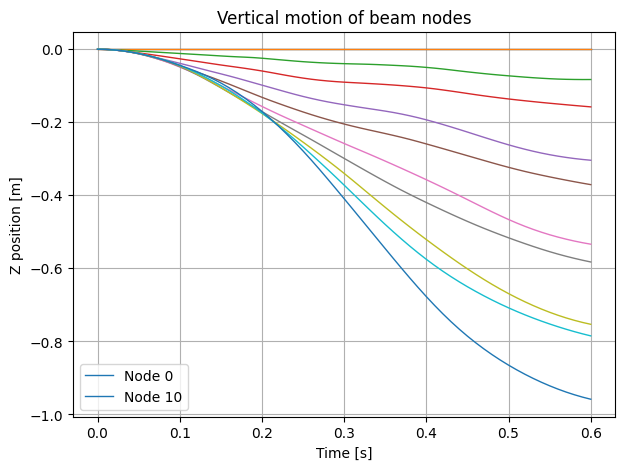

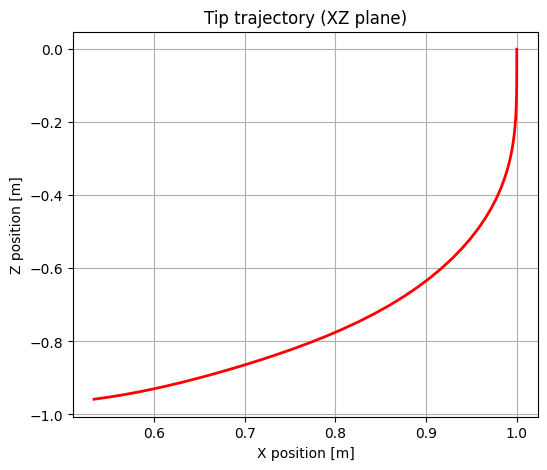

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Convert trajectory to numpy
q_traj_np = q_traj.detach().cpu().numpy().reshape(len(t), num_nodes, 3)
t_np = t.detach().cpu().numpy()

# Plot Z-displacement (vertical motion) of each node
plt.figure(figsize=(7, 5))
for i in range(num_nodes):
    plt.plot(t_np, q_traj_np[:, i, 2], label=f'Node {i}' if i in [0, num_nodes-1] else "", lw=1)
plt.xlabel("Time [s]")
plt.ylabel("Z position [m]")
plt.title("Vertical motion of beam nodes")
plt.legend()
plt.grid(True)
plt.show()

# Plot trajectory of beam tip (last node)
plt.figure(figsize=(6, 5))
plt.plot(q_traj_np[:, -1, 0], q_traj_np[:, -1, 2], 'r-', lw=2)
plt.xlabel("X position [m]")
plt.ylabel("Z position [m]")
plt.title("Tip trajectory (XZ plane)")
plt.grid(True)
plt.show()


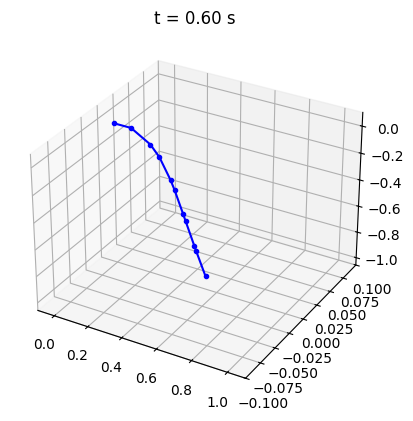

In [16]:
import matplotlib.animation as animation

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def update(frame):
    ax.cla()
    ax.plot(q_traj_np[frame, :, 0],
            q_traj_np[frame, :, 1],
            q_traj_np[frame, :, 2],
            'b.-')
    ax.set_xlim([q_traj_np[:, :, 0].min()-0.1, q_traj_np[:, :, 0].max()+0.1])
    ax.set_ylim([q_traj_np[:, :, 1].min()-0.1, q_traj_np[:, :, 1].max()+0.1])
    ax.set_zlim([q_traj_np[:, :, 2].min()-0.1, q_traj_np[:, :, 2].max()+0.1])
    ax.set_title(f"t = {t[frame]:.2f} s")
    return ax

ani = animation.FuncAnimation(fig, update, frames=range(0, len(t), 1), interval=50)
ani.save("NN_beam_motion.gif", writer="ffmpeg", fps=20)
plt.show()


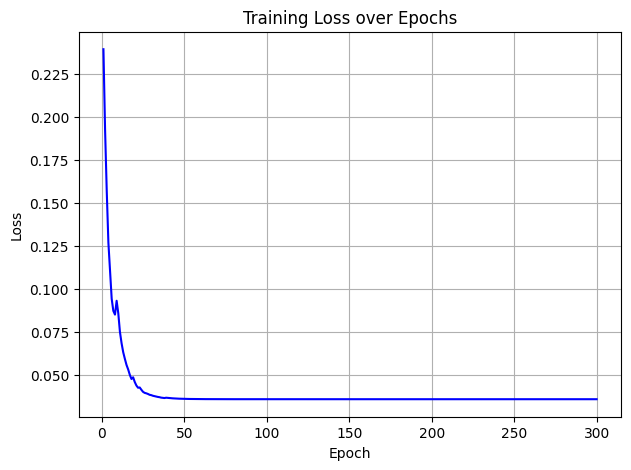

In [17]:
# plot training loss
plt.figure(figsize=(7,5))
plt.plot(range(1, n_epochs + 1), losses, 'b-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.show()